In [17]:
# Import PyTorch
import torch
from torch import nn

# Import torchvision 
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

# Import matplotlib for visualization
import matplotlib.pyplot as plt

# import custom made helper functions
from going_modular.going_modular import engine
from helpers import plot_loss_curves

import os
from pathlib import Path
from helper_functions import walk_through_dir

# setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
image_path = Path("dataset/EarVN1.0/Images/")
train_path = Path("dataset/EarVN1.0/train")
valid_path = Path("dataset/EarVN1.0/valid")
test_path  = Path("dataset/EarVN1.0/test")

In [6]:
walk_through_dir(image_path)

There are 164 directories and 0 images in 'dataset/EarVN1.0/Images'.
There are 0 directories and 160 images in 'dataset/EarVN1.0/Images/080.Thai_V'.
There are 0 directories and 171 images in 'dataset/EarVN1.0/Images/081.Thanh_D'.
There are 0 directories and 143 images in 'dataset/EarVN1.0/Images/126.Le_Thanh_Th'.
There are 0 directories and 196 images in 'dataset/EarVN1.0/Images/014.Dan_Ng'.
There are 0 directories and 140 images in 'dataset/EarVN1.0/Images/111.Hang_Ng'.
There are 0 directories and 182 images in 'dataset/EarVN1.0/Images/123.Lan_Kh'.
There are 0 directories and 160 images in 'dataset/EarVN1.0/Images/122.La_Thanh_H'.
There are 0 directories and 163 images in 'dataset/EarVN1.0/Images/067.Pham_Hong_Ph'.
There are 0 directories and 140 images in 'dataset/EarVN1.0/Images/103.Cha_Mi'.
There are 0 directories and 161 images in 'dataset/EarVN1.0/Images/049.Lee_Min_H'.
There are 0 directories and 200 images in 'dataset/EarVN1.0/Images/031.Hoang_Rap'.
There are 0 directories and 

dataset/EarVN1.0/train/015.Dan_Trg/015 (41).jpg
015
Random image path: dataset/EarVN1.0/train/015.Dan_Trg/015 (41).jpg
Image class: 015
Image height: 160
Image width: 132


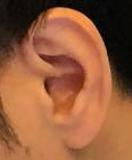

In [10]:
import random
from PIL import Image

#random.seed(69)
# get all image paths
images_path_list = list(train_path.glob("*/*.jpg"))

# plt a random image
rand_image = random.choice(images_path_list)
print(rand_image)

# display the randomly chosen image
image_class = rand_image.parent.stem
print(image_class)

# open image
img = Image.open(rand_image)

# print image metadata
print(f"Random image path: {rand_image}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

In [11]:
## Transforming data with torchvision.transform
# transform images from jpg

IMAGE_SIZE = 128

data_transform = transforms.Compose([
    # Resize images
    transforms.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)),
    # Flip image randomly in horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch tensor
    transforms.ToTensor()
])

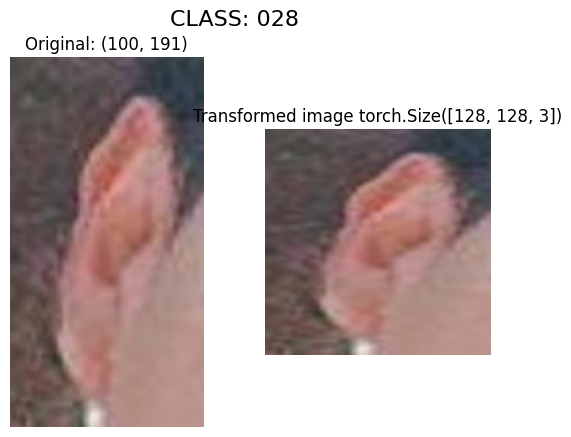

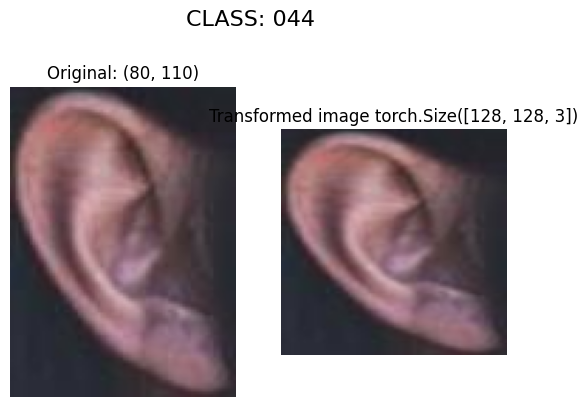

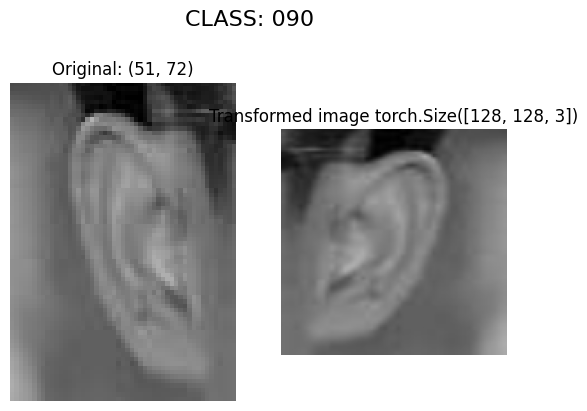

In [12]:
def plot_transformed_images(images_paths: list, transform, n=3, seed=None):
    """ 
    Selects random images from a path of images and loads and transform them and plots
    the orignal + transformed version
    """
    
    if seed:
        random.seed(42)
    random_image_paths = random.sample(images_paths, k=n)
    
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original: {f.size}")
            ax[0].axis(False)
            
            # transform and plot target image
            transformed_image = transform(f).permute(1, 2, 0) # (C,H,W)->(H,W,C)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed image {transformed_image.shape}")
            ax[1].axis("off")
            
            fig.suptitle(f"CLASS: {image_path.parent.stem}", fontsize=16)
            
plot_transformed_images(images_path_list, data_transform, n=3)

In [18]:
train_data = datasets.ImageFolder(
    root=train_path,
    transform=data_transform,
    target_transform=None  # used to transform labels)
)

valid_data = datasets.ImageFolder(
    root=valid_path,
    transform=data_transform,
)

test_data = datasets.ImageFolder(
    root=test_path,
    transform=data_transform
)

train_data, valid_data, test_data

(Dataset ImageFolder
     Number of datapoints: 25132
     Root location: dataset/EarVN1.0/train
     StandardTransform
 Transform: Compose(
                Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 1640
     Root location: dataset/EarVN1.0/valid
     StandardTransform
 Transform: Compose(
                Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 1640
     Root location: dataset/EarVN1.0/test
     StandardTransform
 Transform: Compose(
                Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [19]:
class_names = train_data.classes
class_dict = train_data.class_to_idx
class_dict, len(class_dict)

({'001.ALI_HD': 0,
  '002.LeDuong_BL': 1,
  '003.BD_Tran': 2,
  '004.Binz': 3,
  '005.Bui_AT': 4,
  '006.Chau_GK': 5,
  '007.Chau_KP': 6,
  '008.Chi_D': 7,
  '009.Chi_Th': 8,
  '010.Chu_B': 9,
  '011.Cong_To': 10,
  '012.Dai_Nhan': 11,
  '013.Dam_Vinh_H': 12,
  '014.Dan_Ng': 13,
  '015.Dan_Trg': 14,
  '016.Dang_L': 15,
  '017.Dao_Ba_L': 16,
  '018.De_C': 17,
  '019.Don_Ng': 18,
  '020.Duong_D': 19,
  '021.Dustin_Phuc_Ng': 20,
  '022.Duy_Kh': 21,
  '023.Erik': 22,
  '024.Gin_Tuan_K': 23,
  '025.Ha_Anh_T': 24,
  '026.Hac_Hoa_K': 25,
  '027.Hamtet_Tr': 26,
  '028.Ho_Quang_H': 27,
  '029.Ho_Trung_D': 28,
  '030.Hoai_L': 29,
  '031.Hoang_Rap': 30,
  '032.Huy_Tr': 31,
  '033.Huynh_L': 32,
  '034.Huynh_Ph': 33,
  '035.Isaac': 34,
  '036.Jun_Ph': 35,
  '037.Justatee': 36,
  '038.Kenvin_Kh': 37,
  '039.KhacVi': 38,
  '040.Khuong_Ng': 39,
  '041.Kieu_Minh_T': 40,
  '042.Kim_L': 41,
  '043.L_HA': 42,
  '044.Lam_Canh_T': 43,
  '045.Lam_Hu': 44,
  '046.Lam_Tr': 45,
  '047.Lam_Vinh_H': 46,
  '048.Le

Image tensor 
tensor([[[0.8235, 0.7765, 0.7569,  ..., 0.2314, 0.2314, 0.2314],
         [0.8275, 0.7961, 0.7922,  ..., 0.2235, 0.2196, 0.2196],
         [0.8510, 0.8314, 0.8275,  ..., 0.2196, 0.2235, 0.2235],
         ...,
         [0.8627, 0.8588, 0.8784,  ..., 0.8902, 0.8706, 0.8549],
         [0.8745, 0.8863, 0.8941,  ..., 0.8784, 0.8824, 0.8588],
         [0.8471, 0.8510, 0.8588,  ..., 0.8627, 0.8471, 0.8392]],

        [[0.7294, 0.6824, 0.6627,  ..., 0.2745, 0.2863, 0.2863],
         [0.7333, 0.7020, 0.6980,  ..., 0.2627, 0.2745, 0.2745],
         [0.7569, 0.7373, 0.7333,  ..., 0.2588, 0.2745, 0.2745],
         ...,
         [0.7961, 0.7922, 0.8078,  ..., 0.8078, 0.7882, 0.7725],
         [0.8078, 0.8196, 0.8235,  ..., 0.7961, 0.8000, 0.7765],
         [0.7804, 0.7804, 0.7882,  ..., 0.7804, 0.7608, 0.7569]],

        [[0.6824, 0.6353, 0.6157,  ..., 0.1922, 0.1961, 0.1961],
         [0.6863, 0.6549, 0.6510,  ..., 0.1843, 0.1882, 0.1882],
         [0.7098, 0.6902, 0.6863,  ..., 0.18

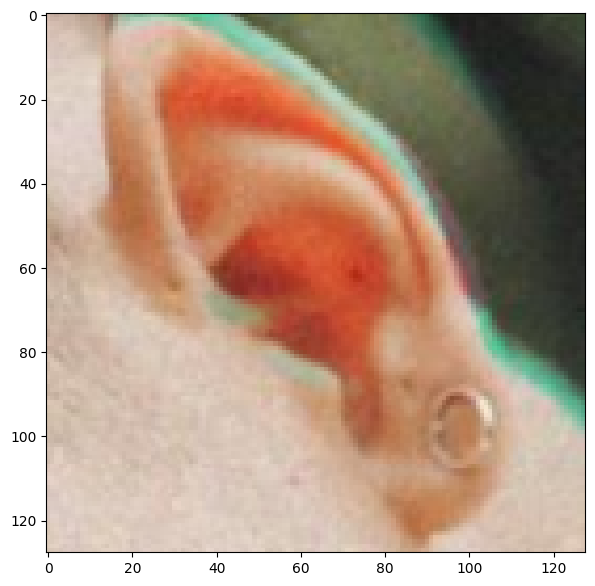

In [20]:
# Visualize smample from train_data dataset

img, label = train_data[123]
print(f"Image tensor \n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Label dtype {type(label), label}")

# rearrange the order dimesniosn
img_permute = img.permute(1, 2, 0)
img_permute

plt.figure(figsize=(10, 7))
plt.imshow(img_permute)

In [41]:
BATCH_SIZE = 128
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True
)

valid_dataloader = DataLoader(
    dataset=valid_data,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False
)

train_dataloader, valid_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x788a7e34da50>,
 <torch.utils.data.dataloader.DataLoader at 0x788a5c95cd50>)

In [42]:
len(train_dataloader), len(valid_dataloader), len(test_dataloader)  # total_samples / batch_size

(197, 13, 13)

In [44]:
img, label = next(iter(train_dataloader))
# batch size is now 1, it can be changed
print(f"Image shape {img.shape} ")
print(f"Label shape {label.shape}")

# for i in range(img.shape[0]):
#     plt.imshow(torch.permute(img[i], [1, 2, 0]))
#     plt.show()

Image shape torch.Size([128, 3, 128, 128]) 
Label shape torch.Size([128])


In [45]:
# Setup the model with pretrained weights and send it to the target device 
weights = torchvision.models.EfficientNet_B4_Weights.DEFAULT # .DEFAULT = best available weights 
model = torchvision.models.efficientnet_b4(weights=weights).to(device)


In [46]:
from torchinfo import summary

summary(
    model=model,
    input_size=(BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [128, 3, 128, 128]   [128, 1000]          --                   True
├─Sequential (features)                                      [128, 3, 128, 128]   [128, 1792, 4, 4]    --                   True
│    └─Conv2dNormActivation (0)                              [128, 3, 128, 128]   [128, 48, 64, 64]    --                   True
│    │    └─Conv2d (0)                                       [128, 3, 128, 128]   [128, 48, 64, 64]    1,296                True
│    │    └─BatchNorm2d (1)                                  [128, 48, 64, 64]    [128, 48, 64, 64]    96                   True
│    │    └─SiLU (2)                                         [128, 48, 64, 64]    [128, 48, 64, 64]    --                   --
│    └─Sequential (1)                                        [128, 48, 64, 64]    [128, 24, 64

In [47]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.features.parameters():
    param.requires_grad = False

model.classifier

Sequential(
  (0): Dropout(p=0.4, inplace=True)
  (1): Linear(in_features=1792, out_features=1000, bias=True)
)

In [48]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1792, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [49]:
# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model, 
        input_size=(BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE), # (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [128, 3, 128, 128]   [128, 164]           --                   Partial
├─Sequential (features)                                      [128, 3, 128, 128]   [128, 1792, 4, 4]    --                   False
│    └─Conv2dNormActivation (0)                              [128, 3, 128, 128]   [128, 48, 64, 64]    --                   False
│    │    └─Conv2d (0)                                       [128, 3, 128, 128]   [128, 48, 64, 64]    (1,296)              False
│    │    └─BatchNorm2d (1)                                  [128, 48, 64, 64]    [128, 48, 64, 64]    (96)                 False
│    │    └─SiLU (2)                                         [128, 48, 64, 64]    [128, 48, 64, 64]    --                   --
│    └─Sequential (1)                                        [128, 48, 64, 64]    [128,

In [50]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

In [59]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the result
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=valid_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=15,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  7%|▋         | 1/15 [00:49<11:28, 49.17s/it]

Epoch: 1 | train_loss: 2.6308 | train_acc: 0.3982 | test_loss: 3.3754 | test_acc: 0.2542


 13%|█▎        | 2/15 [01:38<10:43, 49.47s/it]

Epoch: 2 | train_loss: 2.6367 | train_acc: 0.3979 | test_loss: 3.4293 | test_acc: 0.2467


 20%|██        | 3/15 [02:28<09:56, 49.72s/it]

Epoch: 3 | train_loss: 2.6140 | train_acc: 0.4028 | test_loss: 3.3950 | test_acc: 0.2562


 27%|██▋       | 4/15 [03:18<09:08, 49.84s/it]

Epoch: 4 | train_loss: 2.6194 | train_acc: 0.4001 | test_loss: 3.3972 | test_acc: 0.2525


 33%|███▎      | 5/15 [04:08<08:19, 49.91s/it]

Epoch: 5 | train_loss: 2.6074 | train_acc: 0.4022 | test_loss: 3.4303 | test_acc: 0.2350


 40%|████      | 6/15 [04:58<07:29, 49.95s/it]

Epoch: 6 | train_loss: 2.7937 | train_acc: 0.3604 | test_loss: 3.3882 | test_acc: 0.2507


 47%|████▋     | 7/15 [05:48<06:39, 49.97s/it]

Epoch: 7 | train_loss: 2.7814 | train_acc: 0.3564 | test_loss: 3.4032 | test_acc: 0.2554


 53%|█████▎    | 8/15 [06:38<05:49, 49.97s/it]

Epoch: 8 | train_loss: 2.7715 | train_acc: 0.3619 | test_loss: 3.4189 | test_acc: 0.2510


 60%|██████    | 9/15 [07:28<04:59, 49.99s/it]

Epoch: 9 | train_loss: 2.7760 | train_acc: 0.3585 | test_loss: 3.3769 | test_acc: 0.2468


 67%|██████▋   | 10/15 [08:19<04:10, 50.01s/it]

Epoch: 10 | train_loss: 2.7682 | train_acc: 0.3592 | test_loss: 3.4039 | test_acc: 0.2426


 73%|███████▎  | 11/15 [09:09<03:20, 50.00s/it]

Epoch: 11 | train_loss: 2.7486 | train_acc: 0.3616 | test_loss: 3.4093 | test_acc: 0.2527


 80%|████████  | 12/15 [09:58<02:29, 50.00s/it]

Epoch: 12 | train_loss: 2.7496 | train_acc: 0.3620 | test_loss: 3.3909 | test_acc: 0.2445


 87%|████████▋ | 13/15 [10:49<01:40, 50.01s/it]

Epoch: 13 | train_loss: 2.7477 | train_acc: 0.3639 | test_loss: 3.4219 | test_acc: 0.2379


 93%|█████████▎| 14/15 [11:38<00:49, 49.99s/it]

Epoch: 14 | train_loss: 2.7342 | train_acc: 0.3647 | test_loss: 3.4149 | test_acc: 0.2339


100%|██████████| 15/15 [12:28<00:00, 49.93s/it]

Epoch: 15 | train_loss: 2.7230 | train_acc: 0.3674 | test_loss: 3.3949 | test_acc: 0.2632
[INFO] Total training time: 748.964 seconds


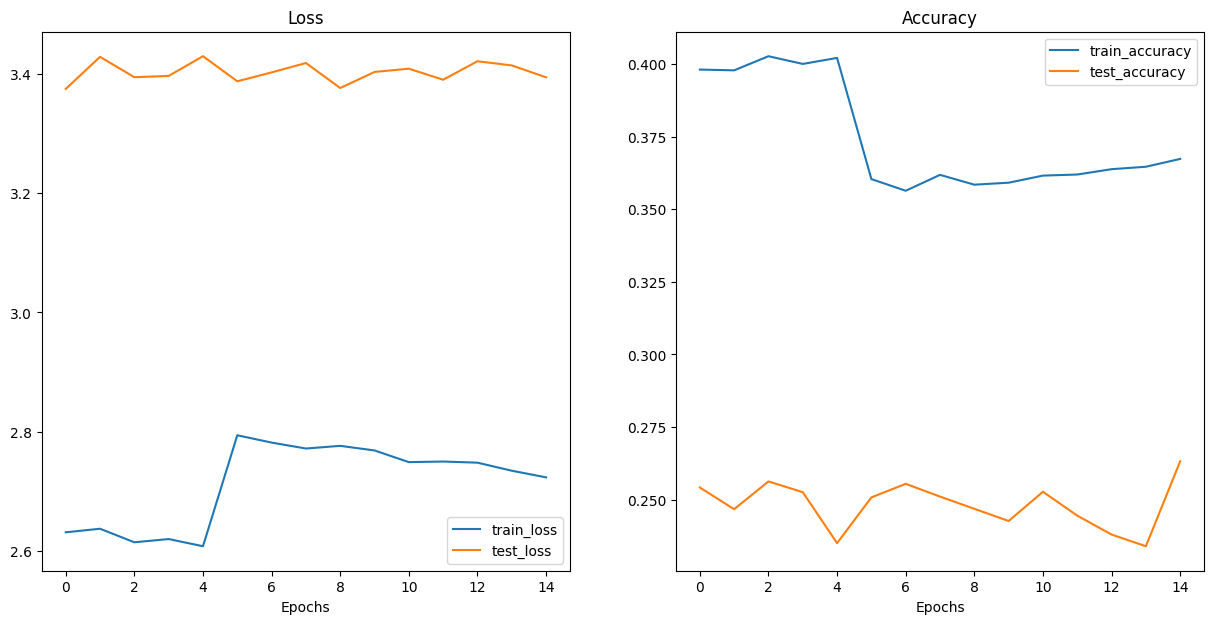

In [60]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helpers import plot_loss_curves
except:
    print("[INFO] Couldn't find helpers.py, downloading...")
    with open("helpers.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helpers.py")
        f.write(request.content)
    from dataset.helpers import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

In [57]:
res = results

In [58]:
res

{'train_loss': [2.976941788862199,
  2.959569793062162,
  2.915764492780424,
  2.899536297406037,
  2.872598881648882,
  3.170015591655286,
  3.136183363532052,
  3.104192633314181,
  3.0929975933229863,
  3.0696064082499084,
  3.0358081202821685,
  3.0232641007089374,
  3.009193224350208,
  2.988612896294763,
  2.9676754026848653],
 'train_acc': [0.3504088313336409,
  0.35032951661282874,
  0.36018977849561606,
  0.3564691970466082,
  0.3624250115366866,
  0.29105618366405167,
  0.29246582256575915,
  0.30484612944162437,
  0.3017059875403784,
  0.304968706737425,
  0.3112778322565759,
  0.31516425357637284,
  0.3191083583294878,
  0.3201358444854638,
  0.3237086121365944],
 'test_loss': [3.5594690396235538,
  3.58575177192688,
  3.5427987575531006,
  3.533045071821946,
  3.5514408625089207,
  3.4984532319582424,
  3.4966576466193566,
  3.4987743084247294,
  3.45077736561115,
  3.4605618623586802,
  3.4578339136563816,
  3.436058136133047,
  3.46428658412053,
  3.4445190796485314,
  3